In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from data_preprocess import Preprocessor

In [240]:
faulty_test_df = pd.read_csv('data/FaultyMotorON_1.csv')
normal_test_df = pd.read_csv('data/NormalMotorON_1.csv')
faulty_test_df_2 = pd.read_csv('data/ImbalancedMotorON_1.csv')
normal_test_df_2 = pd.read_csv('data/NormalMotorON_2.csv')

In [241]:
test_df = [faulty_test_df['Volt'], normal_test_df['Volt0'], faulty_test_df_2['Volt'], normal_test_df_2['Volt']]
types = ['faulty', 'normal', 'faulty', 'normal']
sr = [40000, 30000, 40000, 40000]

In [242]:
data_interval = 3
preprocessor = Preprocessor(max_freq=500, kaiser_beta=10)

In [243]:
test_split = []
for i in range(len(test_df)):
    test_split.append(preprocessor.split_in_intervals(test_df[i], sr[i], data_interval))

c:\Users\rarora\DataspellProjects\PredictiveAnalysis\venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [289]:
test_fft_amp = []
test_fft_freq = []
for i in range(len(test_split)):
    amp, freq = preprocessor.get_fft_of_split_data(test_split[i], sr[i])
    for j in range(len(amp)):
        indices = np.where((freq > 250))
        amp[j][indices] = 0
    test_fft_amp.append(amp)
    test_fft_freq.append(freq)

(0.0, 0.04)

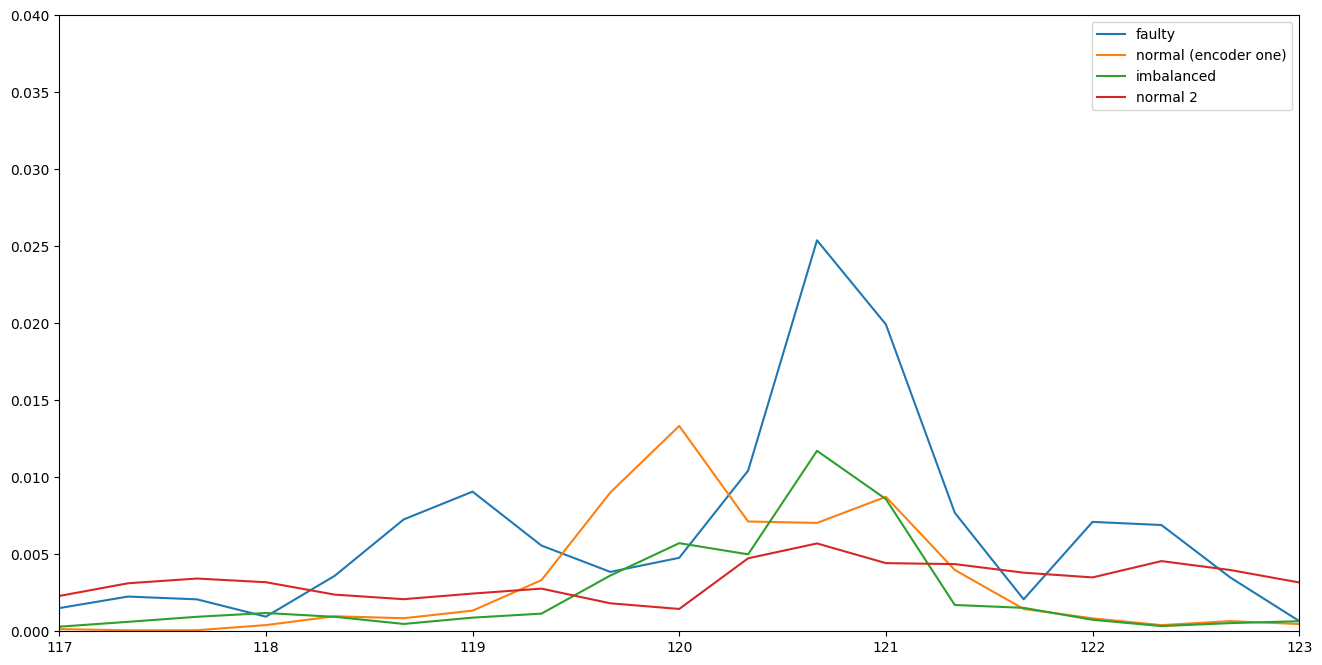

In [303]:
plt.figure(figsize=(16, 8))
plt.plot(test_fft_freq[0], test_fft_amp[0][50], label='faulty')
plt.plot(test_fft_freq[1], test_fft_amp[1][50], label='normal (encoder one)')
plt.plot(test_fft_freq[2], test_fft_amp[2][50], label='imbalanced')
plt.plot(test_fft_freq[3], test_fft_amp[3][50], label='normal 2')
plt.legend()
plt.xlim(117, 123)
plt.ylim(0, 0.04)

In [291]:
test_full = []
for i in range(len(test_fft_amp)):
    test_full.append(preprocessor.add_type_column(test_fft_amp[i], types[i]))

In [292]:
test_data = np.concatenate(test_full, axis=0)

In [293]:
X_test = test_data[:, :-1]
y_test = test_data[:, -1]

In [294]:
model = keras.models.load_model('models/cnn_0.98_500hz_f32_f64_n64_n32_batch32_epochs64_more_data.keras')

In [295]:
model.evaluate(X_test, y_test)

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9998 - loss: 4.8982e-04


[0.0022299084812402725, 0.999009907245636]

In [296]:
z = model.predict(X_test)
print(z)

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
[[1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 ...
 [9.3456513e-11]
 [3.8220456e-08]
 [5.3453487e-06]]


In [297]:
predictionsvreal = pd.DataFrame({'predictions': z.flatten(), 'real': y_test})

In [298]:
# format predictions and chop off decimals after 1st
#predictionsvreal['predictions'] = predictionsvreal['predictions'].apply(lambda x: round(x, 1))

In [299]:
predictionsvreal.head()

,predictions,real
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
